In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from __future__ import division
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.calibration import calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
import pickle

In [2]:
# from 
#https://www.ibm.com/developerworks/community/blogs/jfp/entry/Fast_Computation_of_AUC_ROC_score?lang=en
# AUC-ROC = | {(i,j), i in pos, j in neg, p(i) > p(j)} | / (| pos | x | neg |)
# The equivalent version of this is, Pr [ LEFT > RIGHT ]
# now Y_true is group membership (of positive examples) , not positive level 

def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true) 
    y_true = y_true[np.argsort(y_prob)] #sort the predictions first
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n): # visit the examples in increasing order of predictions.
        y_i = y_true[i]
        nfalse += (1 - y_i) # negative (RIGHT) examples seen so far 
        auc += y_i * nfalse # Each time we see a positive (LEFT) example we add the number of negative examples we've seen so far
    auc /= (nfalse * (n - nfalse))
    return auc
''' 
cross_auc for the Ra0 > Rb1 error
function takes in scores for (a,0), (b,1)
'''
def cross_auc(R_a_0, R_b_1): 
    scores = np.hstack(np.asarray([R_a_0, R_b_1]))
    y_true = np.zeros(len(R_a_0)+len(R_b_1))
    y_true[0:len(R_a_0)] = 1 # Pr[ LEFT > RIGHT]; Y = 1 is the left (A0)
    return fast_auc(y_true, scores)


In [ ]:
compas_scores = pd.read_csv("fairness-datasets/compas-analysis-master/compas-scores.csv")

In [260]:
# preprocessing
# https://github.com/algofairness/fairness-comparison/blob/master/fairness/data/objects/PropublicaRecidivism.py
#       self.positive_class_val = 1
#         self.sensitive_attrs = ['sex', 'race']
#         self.privileged_class_names = ['Male', 'Caucasian']
# 1 is white

compas = pd.read_csv("fairness-datasets/fairness/data/preprocessed/propublica-recidivism_numerical-binsensitive.csv")
X_full = compas.loc[:, compas.columns != 'two_year_recid']
X_norace = X_full.loc[:, X_full.columns != 'race']
X_norace = X_norace.loc[:, X_norace.columns != 'sex-race']

Y = compas['two_year_recid'].values.astype(int)
A = compas['race'].values.astype(int)
classes = ['black', 'white']
X_compas = X_full; Y_compas = Y; A_compas = A; compas_classes = classes
clf_0 = LogisticRegression(); clf_0.fit(X_full, Y)
Rhat = clf_0.predict_proba(X_full)[:,1]
print clf_0.classes_

[0 1]


In [266]:
# print A
# print Y
# print X_full
compas_data = { 'A_compas': A, 'Y_compas': Y, 'X_compas': X_full, 'classes_compas': classes }
pickle.dump( compas_data, open('compas_processed.p','wb'))


In [ ]:
# If a person recidivates, label_value = 1 
# Here, b is white (1) (privileged)
# a is black (less privileged)


In [8]:
class_levels = np.unique(A)
AUCs = np.zeros(len(class_levels))
for ind,a in enumerate(class_levels): 
    fpr, tpr, thresholds = metrics.roc_curve(Y[A==a], Rhat[A==a], pos_label=1)
    AUCs[ind] = metrics.auc(fpr,tpr)
    
def get_AUCs(Rhat, Y, A): 
    class_levels = np.unique(A); AUCs = np.zeros(len(class_levels))
    for ind,a in enumerate(class_levels): 
        fpr, tpr, thresholds = metrics.roc_curve(Y[A==a], Rhat[A==a], pos_label=1)
        AUCs[ind] = metrics.auc(fpr,tpr)
    return AUCs

In [9]:
print [ (AUCs[i], classes[i]) for i in class_levels ]


[(0.7727605638573807, 'black'), (0.7347779567374509, 'white')]


In [268]:
import seaborn as sns
import imp
imp.reload(plt); imp.reload(sns)

def get_cross_aucs(Rhat, Y, A, quiet=True, stump="def", save=False): 
    Rhat_a_0 = Rhat[(A==0)&(Y==0)] # a (0) is black 
    Rhat_b_1 = Rhat[(A==1)&(Y==1)] # b (1) is white
    Rhat_b_0 = Rhat[(A==1)&(Y==0)] # b is white 
    Rhat_a_1 = Rhat[(A==0)&(Y==1)] # a is black
    if not quiet:
        plt.figure(figsize=(7,3))#  plt.figure(figsize=(3,3))
# Densities kde
        ax1 = plt.subplot(121)
        sns.set_style("white")
        sns.kdeplot(Rhat_a_0, shade=True, color = 'r', label='A=a, Y=0', clip = (0,1))
        sns.kdeplot(Rhat_b_1, shade=True, color = 'b', label='A=b, Y=1', clip = (0,1))
        plt.xlim((0,1))
        plt.title(r'KDEs of $R_A^Y$ for XAUC')
# Normed histograms
#         plt.hist(Rhat_b_1, alpha=0.5, color='blue', label='A=b, Y=1', density=True)
#         plt.hist(Rhat_a_0, alpha=0.5, color='red', label='A=a, Y=0', density=True)
        plt.legend()
#         plt.figure(figsize=(3,3))
        plt.subplot(122, sharey = ax1)
        sns.kdeplot(Rhat_b_0, shade=True, color = 'r', label='A=b, Y=0', clip = (0,1))
        sns.kdeplot(Rhat_a_1, shade=True, color = 'b', label='A=a, Y=1', clip = (0,1))
        plt.xlim((0,1))
        plt.title(r'KDEs of $R_A^Y$ for XAUC')
#         plt.hist(Rhat_b_0, alpha=0.5, color='blue', label='A=b,Y=0', density=True)
#         plt.hist(Rhat_a_1, alpha=0.5, color='red', label='A=a, Y=1', density=True)
        plt.legend()
        if save: 
            plt.savefig('figs/'+stump+'KDEs.pdf')
    # What's the probability that a black innocent is misranked above an actually offending white?
    Rhata0_cross_Rhatb1 = cross_auc(Rhat_a_0, Rhat_b_1)
    # What's the probability that a white innocent is misranked above an actually offending black?
    Rhatb0_cross_Rhata1 = cross_auc(Rhat_b_0, Rhat_a_1)
    return [Rhata0_cross_Rhatb1,Rhatb0_cross_Rhata1]

[0.3570354903612203, 0.15753059991667276]


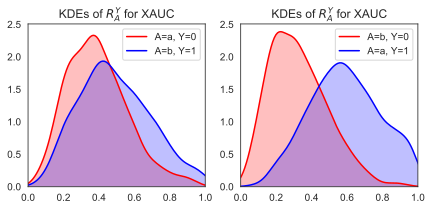

In [226]:
[Rhata0_cross_Rhatb1,Rhatb0_cross_Rhata1] = get_cross_aucs(Rhat, Y, A,quiet=False)
print [Rhata0_cross_Rhatb1,Rhatb0_cross_Rhata1]

[array([0.19592785, 0.19884539]),
 array([0.07307649, 0.1587773 , 0.24977267, 0.35001283, 0.4466968 ,
        0.54658407, 0.64337482, 0.73975087, 0.84323414, 0.94989565]),
 array([0.05797101, 0.15151515, 0.25061425, 0.33902439, 0.46175637,
        0.53138075, 0.66455696, 0.79569892, 0.79545455, 0.93333333])]

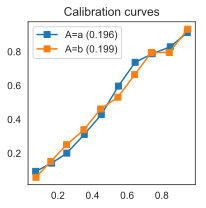

In [174]:
imp.reload(plt);
# https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
A_labels = ['a', 'b']

def get_calib_curves(Rhat, Y, A, A_labels, stump = 'def', save = False):
    plt.figure(figsize=(3,3))
    clf_scores = np.zeros(len(np.unique(A)))
    for ind,a in enumerate(np.unique(A)): 
        clf_scores[ind] = brier_score_loss(Y[A==a], Rhat[A==a], pos_label=Y.max())
        fraction_of_positives, mean_predicted_value = calibration_curve(Y[A==a], Rhat[A==a] , n_bins = 10)
        plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                     label="A=%s (%1.3f)" % (A_labels[a], clf_scores[ind]))
    plt.legend()
    plt.title('Calibration curves')
    if save: 
        plt.savefig('figs/'+stump+'calibration-curves.pdf')
    return [clf_scores, mean_predicted_value, fraction_of_positives]

get_calib_curves(Rhat, Y, A, A_labels)

[0.3570354903612203, 0.15753059991667276]

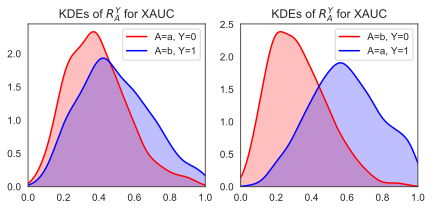

In [210]:
# train a race-blind score
clf_0 = LogisticRegression(); clf_0.fit(X_norace, Y)
Rhat_norace = clf_0.predict_proba(X_norace)[:,1]
get_cross_aucs(Rhat, Y, A,quiet=False)


In [157]:
# plt.figure()
# plt.hist(Rhat_b_1, alpha=0.5, color='blue', label='A=b, Y=1')
# plt.hist(Rhat_a_1, alpha=0.5, color='red', label='A=a, Y=1')

In [158]:
n_thresh = 200
thresholds = np.linspace(1,0,n_thresh)


def get_roc(n_thresh, Rhat, Y):
    thresholds = np.linspace(1,0,n_thresh)
    ROC = np.zeros((n_thresh,2))
    for i in range(n_thresh):
        t = thresholds[i]
        # Classifier / label agree and disagreements for current threshold.
        TP_t = np.logical_and( Rhat > t, Y==1 ).sum()
        TN_t = np.logical_and( Rhat <=t, Y==0 ).sum()
        FP_t = np.logical_and( Rhat > t, Y==0 ).sum()
        FN_t = np.logical_and( Rhat <=t, Y==1 ).sum()
        # Compute false positive rate for current threshold.
        FPR_t = FP_t / float(FP_t + TN_t)
        ROC[i,0] = FPR_t
        # Compute true  positive rate for current threshold.
        TPR_t = TP_t / float(TP_t + FN_t)
        ROC[i,1] = TPR_t
    return ROC

''' Cross ROC defined for Ra0 > R1b 
(permute identity of a,b, to compute the other way)
Returns a XROC with FPR on Y axis, TPR on X axis
Assume Rhat_a, Rhat_b are already separate subsets of A=a, A=b
'''
def get_cross_roc(n_thresh, Rhat_a, Rhat_b, Y_a, Y_b, A):
    thresholds = np.linspace(1,0,n_thresh)
    XROC = np.zeros((n_thresh,2))
    for i in range(n_thresh):
        t = thresholds[i]
        # Classifier / label agree and disagreements for current threshold.
        TP_t_b = np.logical_and( Rhat_b > t, Y_b==1 ).sum()
        TN_t_a = np.logical_and( Rhat_a <=t, Y_a==0 ).sum()
        FP_t_a = np.logical_and( Rhat_a > t, Y_a==0 ).sum()
        FN_t_b = np.logical_and( Rhat_b <=t, Y_b==1 ).sum()
        # Compute false positive rate for current threshold.
        FPR_t_a = FP_t_a*1.0 / (FP_t_a + TN_t_a)

        XROC[i,1] = FPR_t_a
        # Compute true  positive rate for current threshold.
        TPR_t_b = TP_t_b*1.0 / (TP_t_b + FN_t_b)
        XROC[i,0] = TPR_t_b
    return XROC


Text(0.5,1,'XROC curve, $R_b^0 > R_a^1$')

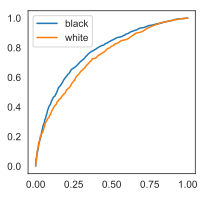

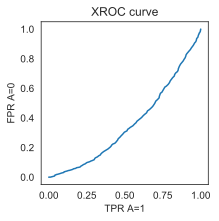

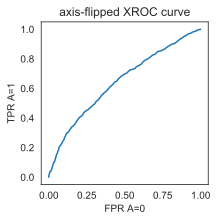

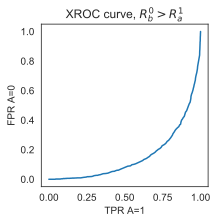

In [159]:
n_thresh = 200; 

ROCs_A = [None] * len(np.unique(A))
ROCs = [ get_roc(n_thresh, Rhat[A==a], Y[A==a]) for a in np.unique(A) ] 
plt.figure(figsize=(3,3))
[ plt.plot(ROCs[a][:,0], ROCs[a][:,1], label = classes[a]) for a in range(len(np.unique(A))) ]
plt.legend()
XROC = get_cross_roc(n_thresh, Rhat[A==0], Rhat[A==1], Y[A==0], Y[A==1], A)
plt.figure(figsize=(3,3))
plt.plot(XROC[:,0], XROC[:,1])
plt.xlabel('TPR A=1')
plt.ylabel('FPR A=0')
plt.title('XROC curve')

plt.figure(figsize=(3,3))
plt.plot(XROC[:,1], XROC[:,0])
plt.ylabel('TPR A=1')
plt.xlabel('FPR A=0')
plt.title('axis-flipped XROC curve')

XROC_backwards = get_cross_roc(n_thresh, Rhat[A==1], Rhat[A==0],Y[A==1], Y[A==0], A)
plt.figure(figsize=(3,3))
plt.plot(XROC_backwards[:,0], XROC_backwards[:,1])
plt.xlabel('TPR A=1')
plt.ylabel('FPR A=0')
plt.title(r'XROC curve, $R_b^0 > R_a^1$')

In [213]:
n_thresh = 200;
''' For now assumes that A \in \{0,1\}
'''
def get_rocs_xrocs(Rhat, Y, A, classes, n_thresh): 
    ROCs_A = [None] * len(np.unique(A))
    ROCs = [ get_roc(n_thresh, Rhat[A==a], Y[A==a]) for a in np.unique(A) ] 
    XROC = get_cross_roc(n_thresh, Rhat[A==0], Rhat[A==1], Y[A==0], Y[A==1], A)
    XROC_backwards = get_cross_roc(n_thresh, Rhat[A==1], Rhat[A==0],Y[A==1], Y[A==0], A)
    return [ROCs, XROC, XROC_backwards]

def plot_ROCS(ROCs, XROC, XROC_backwards, classes, A, stump = 'def', save = False):
    plt.figure(figsize=(6.5,3))
    plt.subplot(121)#     
#     plt.figure(figsize=(3,3))
    [ plt.plot(ROCs[a][:,0], ROCs[a][:,1], label = classes[a]) for a in range(len(np.unique(A))) ]
    plt.legend()
    if save: 
        plt.savefig('figs/'+stump+'ROC.pdf')
    plt.title('ROC curve')
    plt.subplot(122) #     
#     plt.figure(figsize=(3,3))
    plt.plot(XROC[:,0], XROC[:,1], label = r'$R_a^0 > R_b^1$', color = 'blue')
    plt.plot(XROC_backwards[:,0], XROC_backwards[:,1], label = r'$R_b^0 > R_a^1$', color = 'red')
    plt.xlabel('TPR')
    plt.ylabel('FPR')
    plt.title(r'XROC curve')
    plt.legend()
    if save: 
        plt.savefig('figs/'+stump+'XROC.pdf')
    
    
#     if save: 
#         plt.savefig('figs/'+stump+'XROC_backwards.pdf')
#     plt.xlabel('TPR A=1')
#     plt.ylabel('FPR A=0')
#     plt.title(r'XROC curve, $R_b^0 > R_a^1$')

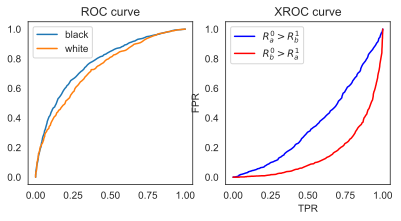

In [214]:

[ROCs, XROC, XROC_backwards] = get_rocs_xrocs(Rhat, Y, A, classes, n_thresh)
plot_ROCS(ROCs, XROC, XROC_backwards, classes, A)

### Code to run this for multiple datasets 

In [262]:
''' Print diagnostics for given score Rhat, 
Get AUCs, XAUCs; ROC curves
'''
def get_diagnostics(Rhat, X, A, Y,labels, n_thresh): 
    [briers, mean_predicted_value, fraction_of_positives] = get_calib_curves(Rhat, Y, A, labels)
    AUCs = get_AUCs(Rhat, Y, A)
    print 'AUCs',[ (AUCs[i], labels[i]) for i in range(len(np.unique(A))) ]
    [ROCs, XROC, XROC_backwards] = get_rocs_xrocs(Rhat, Y, A, labels, n_thresh)
    plot_ROCS(ROCs, XROC, XROC_backwards, labels, A)
    [Rhata0_cross_Rhatb1,Rhatb0_cross_Rhata1] = get_cross_aucs(Rhat, Y,A, quiet=False)
    print 'XAUCs', [Rhata0_cross_Rhatb1,Rhatb0_cross_Rhata1]
    return [AUCs, briers, ROCs, XROC, XROC_backwards, Rhata0_cross_Rhatb1,Rhatb0_cross_Rhata1]

def get_lr(X,Y):
    clf = LogisticRegression(); clf.fit(X,Y)
    Rhat = clf.predict_proba(X)[:,1]
    return [clf, Rhat]

In [163]:
datasets = ['fairness-datasets/framingham.csv', 'fairness-datasets/parole.csv']
dataset_names= ['framingham', 'parole']
protected_attributes = [ 'sex', 'race' ]
y_vals = [ 'violator' ]


In [265]:
framingham = pd.read_csv('fairness-datasets/framingham.csv')
# let sex be protected attribute 
A_frm = (framingham['sex'] == 2).values.astype(int)
Y_frm = framingham['chdfate'].values.astype(int)
X_frm = framingham.drop(['sex', 'chdfate', 'id'], axis=1)
null_inds = pd.isnull(X_frm).any(1).nonzero()[0]
X_frm.dropna(inplace=True); 
A_frm= np.delete(A_frm,null_inds); Y_frm= np.delete(Y_frm,null_inds); 
X_frm_array = X_frm.values
X_frm_cols = [c for c in X_frm.columns]
frm_processed = { 'X_frm': X_frm_array, 'frm_cols':X_frm_cols, 'A_frm': A_frm, 'Y_frm':Y_frm, 'classes_frm':['sex1','sex2'], 'frm_classes_dict':{0:'sex1',1:'sex2'}  }
pickle.dump(frm_processed, open('frm_processed.p','wb'))
# Dropped 40 rows due to missingness (bmi, scl)

In [166]:
clf_frm = LogisticRegression(); clf_frm.fit(X_frm_array, Y_frm)
Rhat_frm = clf_frm.predict_proba(X_frm_array)[:,1]


Framingham baseline

Text(0.5,1,'out of sample calibration curves')

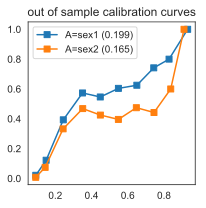

In [182]:
n_thresh = 700
frm_labels = ['sex1', 'sex2']
get_calib_curves(Rhat_frm, Y_frm, A_frm, frm_labels)
plt.title('out of sample calibration curves')

AUCs [(0.7705277705277706, 'sex1'), (0.770670972563254, 'sex2')]
[0.26318325079934984, 0.20087761010681904]


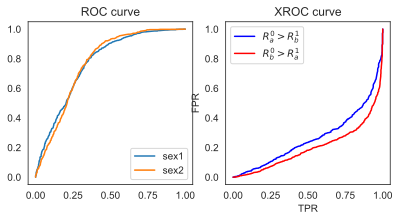

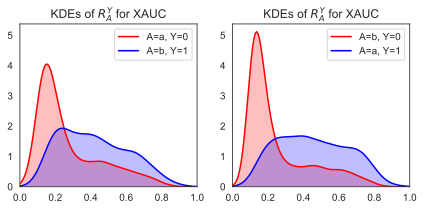

In [238]:
AUCs_frm = get_AUCs(Rhat_frm, Y_frm, A_frm)
print 'AUCs',[ (AUCs_frm[i], frm_labels[i]) for i in range(len(np.unique(A_frm))) ]
[ROCs, XROC, XROC_backwards] = get_rocs_xrocs(Rhat_frm, Y_frm, A_frm, frm_labels, n_thresh)
plot_ROCS(ROCs, XROC, XROC_backwards, frm_labels, A)
[Rhata0_cross_Rhatb1_frm,Rhatb0_cross_Rhata1_frm] = get_cross_aucs(Rhat_frm, Y_frm,A_frm, quiet=False)
XAUCs = get_cross_aucs(Rhat_frm, Y_frm, A_frm)
print XAUCs

## Does learning a better calibrated classifier improve XAUC? 

In [269]:
framingham.head()

,sex,sbp,dbp,scl,chdfate,followup,age,bmi,month,id
0,1,120,80,267.0,1,18,55,25.000000,8,2642
1,1,130,78,192.0,1,35,53,28.400000,12,4627
2,1,144,90,207.0,1,109,61,25.100000,8,2568
3,1,92,66,231.0,1,147,48,26.200001,11,4192
4,1,162,98,271.0,1,169,39,28.400000,11,3977


In [ ]:
framingham = pd.read_csv('fairness-datasets/framingham.csv')
# let sex be protected attribute 
A_frm = (framingham['sex'] == 2).values.astype(int)
Y_frm = framingham['chdfate'].values.astype(int)
X_frm = framingham.drop(['sex', 'chdfate', 'id'], axis=1)
null_inds = pd.isnull(X_frm).any(1).nonzero()[0]
X_frm.dropna(inplace=True); 
A_frm= np.delete(A_frm,null_inds); Y_frm= np.delete(Y_frm,null_inds); 
X_frm_array = X_frm.values
X_frm_cols = [c for c in X_frm.columns]
frm_processed = { 'X': X_frm_array, 'cols':X_frm_cols, 'A': A_frm, 'Y':Y_frm,'classes':{0:'sex1',1:'sex2'}  }
pickle.dump(frm_processed, open('frm_processed.p','wb'))
# Dropped 40 rows due to missingness (bmi, scl)

## German

In [257]:
german = pd.read_csv('fairness-datasets/german_numerical_binsensitive.csv')
A_german = german['age'] > 25 # older = privileged 
# Can also consider sex 
#A_german = german['sex'] 
Y_german = (german['credit'] == 2).values.astype(int)
X_german = german.drop(['age', 'credit'], axis=1)
# null_inds = pd.isnull(X_frm).any(1).nonzero()[0]
# X_frm.dropna(inplace=True); 
# A_frm= np.delete(A_frm,null_inds); Y_frm= np.delete(Y_frm,null_inds); 
X_german_array = X_german.values
X_german_cols = [c for c in X_german.columns]
classes_german = {0:'age<25',1:'age>25'}
german_labels = classes_german.values()
german_processed = { 'X_german': X_german_array, 'german_cols':X_german_cols, 'A_german': A_german, 'Y_german':Y_german, 'classes_german': german_labels, 'german_classes_dict':classes_german  }
pickle.dump(german_processed, open('german_processed.p','wb'))

/Users/az/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  if sys.path[0] == '':


AUCs [(0.7809090909090909, 'age<25'), (0.8358320493066256, 'age>25')]
XAUCs [0.2377685950413223, 0.1473728813559322]


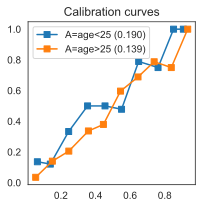

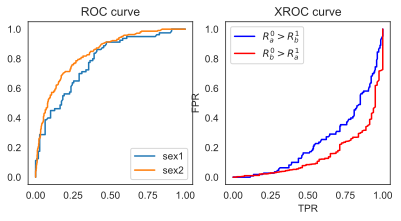

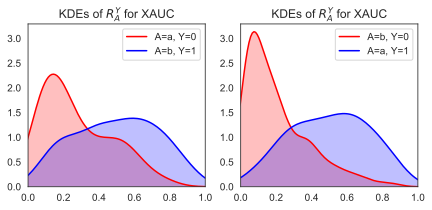

In [239]:
[clf_german, Rhat_german] = get_lr(X_german_array, Y_german)
n_thresh = 700
[AUCs, briers, ROCs_g, XROC_g, XROC_backwards_g, Rhata0_cross_Rhatb1_g,Rhatb0_cross_Rhata1_g] = get_diagnostics(Rhat_german, X_german_array, A_german, Y_german,german_labels, n_thresh)

## Adult 

In [267]:
adult = pd.read_csv('fairness-datasets/adult_numerical-binsensitive.csv')
print adult.shape
A_adult = adult['race'] # privileged = White, race # Can also consider sex 
Y_adult = (adult['income-per-year']).values.astype(int) # predict income > 50K
print Y_adult.shape
X_adult = adult.drop(['race', 'income-per-year'], axis=1)
X_adult_array = X_adult.values
X_adult_cols = [c for c in X_adult.columns]
classes_adult = {0:'black',1:'white'}
adult_labels = classes_adult.values()
adult_processed = { 'X_adult': X_adult_array, 'cols_adult':X_adult_cols, 'A_adult': A_adult, 'Y_adult':Y_adult,'classes_adult':adult_labels, 'adult_classes_dict':classes_adult  }
pickle.dump(adult_processed, open('adult_processed.p','wb'))
adult.head()

(30162, 100)
(30162,)


,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,income-per-year,race-sex,workclass_Federal-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,13,1,1,2174,0,40,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,50,13,1,1,0,0,13,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,38,9,1,1,0,0,40,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,53,7,0,1,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,13,0,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0


AUCs [(0.92476003930065, 'black'), (0.9005474190816192, 'white')]
XAUCs [0.05269012323570533, 0.13575907910873794]
25933


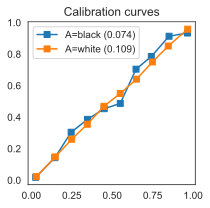

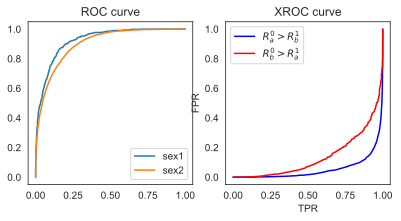

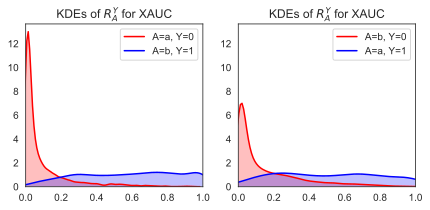

In [235]:
[clf_adult, Rhat_adult] = get_lr(X_adult_array, Y_adult)
[AUCs_a, ROCs_a, XROC_a, XROC_backwards_a, Rhata0_cross_Rhatb1_a,Rhatb0_cross_Rhata1_a] = get_diagnostics(Rhat_adult, X_adult_array, A_adult, Y_adult,adult_labels, n_thresh)
print sum(A)

## Train calibrated versions of each LR classifier

(4699, 10)

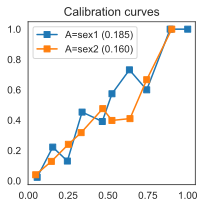

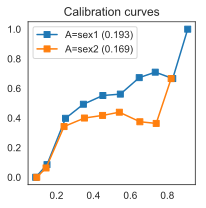

In [192]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split

base_est = LogisticRegression()
x_train_frm, x_test_frm, y_train_frm, y_test_frm, A_train_frm, A_test_frm, train_ind_frm, test_ind_frm = train_test_split(X_frm_array, Y_frm, A_frm, range(len(A_frm)), test_size = 0.3)
def get_calibrated_isotonic(clf, X_train,X_test, y_train): 
    clf_isotonic = CalibratedClassifierCV(clf, cv=2, method='isotonic') #clf is base estimator
    clf_isotonic.fit(X_train, y_train)
    prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]
    return [ clf_isotonic, prob_pos_isotonic ]

def get_calibrated_sigmoid(clf, X_train,X_test, y_train): 
    clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method='sigmoid') #clf is base estimator
    clf_sigmoid.fit(X_train, y_train)
    prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]
    return [ clf_sigmoid, prob_pos_sigmoid ]

[clf_iso_frm, prob_pos_iso] = get_calibrated_isotonic(base_est, x_train_frm, x_test_frm, y_train_frm)
frm_labels = ['sex1', 'sex2']
[briers, mpvs_iso, fpos_iso] = get_calib_curves(prob_pos_iso, y_test_frm, A_test_frm, frm_labels)
[clf_sig_frm, prob_pos_sig] = get_calibrated_sigmoid(base_est, x_train_frm, x_test_frm, y_train_frm)
[briers_sig, mpvs_sig, fpos_sig] = get_calib_curves(prob_pos_sig, y_test_frm, A_test_frm, frm_labels)




AUCs [(0.775096775096775, 'sex1'), (0.776227871312932, 'sex2')]
XAUCs [0.27130099421121096, 0.21342878442269922]
og xaucs [0.26318325079934984, 0.20087761010681904]


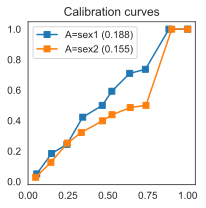

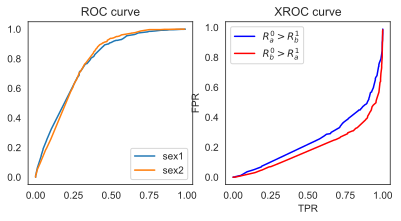

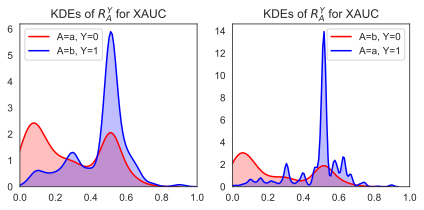

In [216]:
# Let's go with calibration curves from isotonic regression
Rhat_frm_iso = clf_iso_frm.predict_proba(X_frm_array)[:,1]
res_iso = get_diagnostics(Rhat_frm_iso, X_frm_array, A_frm, Y_frm, frm_labels, n_thresh)
[ROCs_f_iso, XROC_f_iso, XROC_backwards_f_iso, Rhata0_cross_Rhatb1_f_iso,Rhatb0_cross_Rhata1_f_iso] = res_iso
print 'og xaucs', [Rhata0_cross_Rhatb1_frm,Rhatb0_cross_Rhata1_frm]



0.7453505007153076
[0.81263835 0.79687923] auc
[0.25298649584487537, 0.14529575228265185] xaucs
AUCs [(0.8663683663683663, 'sex1'), (0.8727675067037599, 'sex2')]
XAUCs [0.15816731451406374, 0.10507049857962637]
only on test
AUCs [(0.8126383529497152, 'sex1'), (0.7968792275432901, 'sex2')]
XAUCs [0.25298649584487537, 0.14529575228265185]


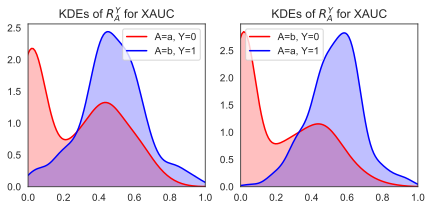

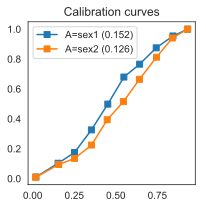

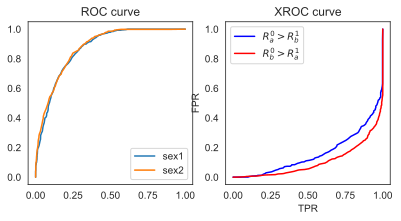

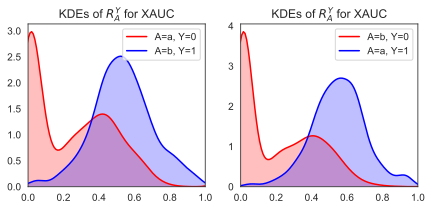

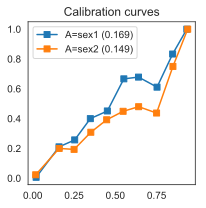

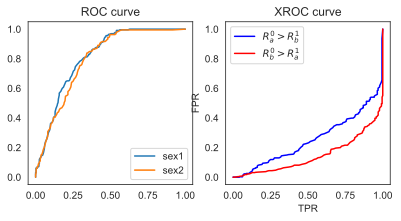

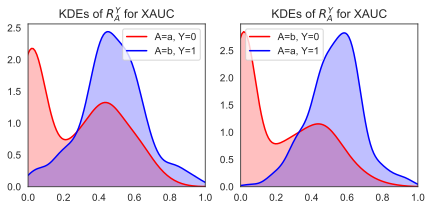

In [222]:
## Try a more complex classifier for framingham 
from sklearn.ensemble import GradientBoostingClassifier
clf_frm_gb = GradientBoostingClassifier()
clf_frm_gb = clf_frm_gb.fit(x_train_frm, y_train_frm)
print clf_frm_gb.score(x_test_frm, y_test_frm) # test error
Rhat_test = clf_frm_gb.predict_proba(x_test_frm)[:,1]
Rhat_all = clf_frm_gb.predict_proba(X_frm_array)[:,1]
auc = get_AUCs(Rhat_test, y_test_frm, A_test_frm)
print auc, 'auc'
xaucs = get_cross_aucs(Rhat_test, y_test_frm, A_test_frm,quiet=False)
print xaucs, 'xaucs'

res_xgboost = get_diagnostics(Rhat_all, X_frm_array, A_frm, Y_frm, frm_labels, n_thresh)
[AUCS_f_dgb, ROCs_f_xgb, XROC_f_xgb, XROC_backwards_f_xgb, Rhata0_cross_Rhatb1_f_xgb,Rhatb0_cross_Rhata1_f_xgb] = res_iso
print 'only on test'
res_xgboost_test = get_diagnostics(Rhat_test, x_test_frm, A_test_frm, y_test_frm, frm_labels, n_thresh)


('dataset: ', 'COMPAS')
AUCs [(0.7334425920316402, 'black'), (0.7098945660989457, 'white')]
XAUCs [0.3869448098728309, 0.1852195221741988]
('dataset: ', 'framingham')
AUCs [(0.7887231241772709, 'sex1'), (0.7758704752938012, 'sex2')]
XAUCs [0.2459187764921526, 0.19305170970442398]
('dataset: ', 'german')
AUCs [(0.6686159844054581, 'age<25'), (0.8093212669683258, 'age>25')]
XAUCs [0.29271255060728746, 0.20784313725490197]
('dataset: ', 'adult')
AUCs [(0.9278065388741196, 'black'), (0.9017241928706565, 'white')]
XAUCs [0.05013584504279901, 0.13233780456675148]


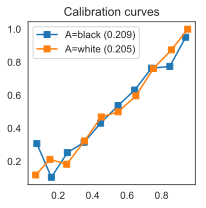

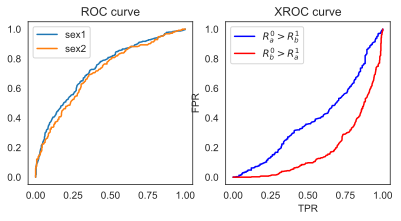

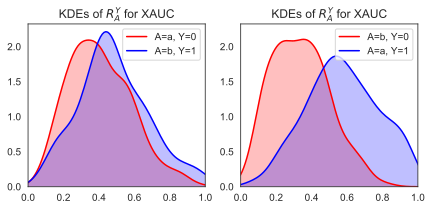

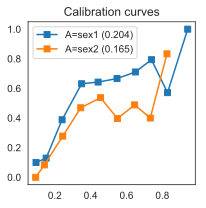

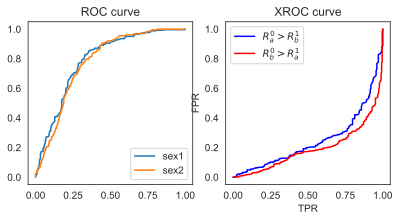

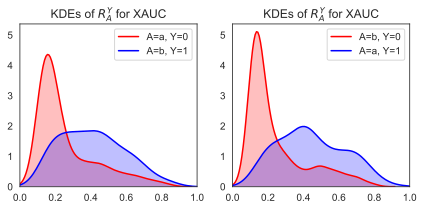

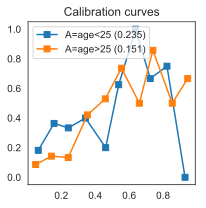

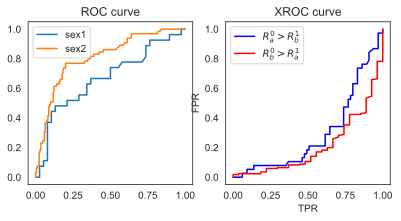

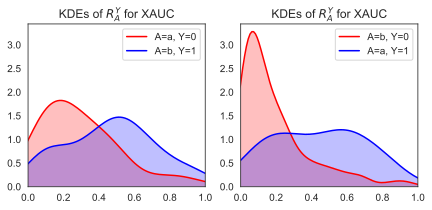

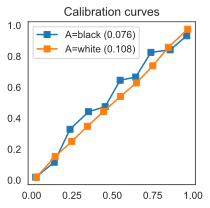

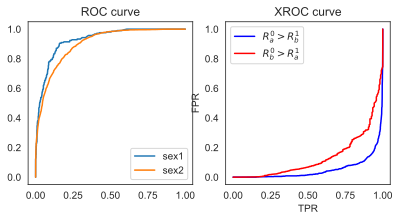

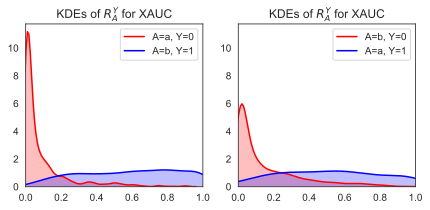

In [247]:



# datasets are X, A, Y, labels, stump for saving output 
cmps = [X_compas, A_compas, Y_compas, compas_classes, 'COMPAS']
frm = [X_frm, A_frm, Y_frm, frm_labels, 'framingham']
gmn = [X_german, A_german, Y_german, classes_german, 'german']
adt = [X_adult, A_adult, Y_adult, classes_adult, 'adult']
datasets = [cmps, frm, gmn, adt]
TEST_SIZE = 0.3
N_THRESH = 700
RES_ = [None] * len(datasets)
for ind,dataset in enumerate(datasets): 
    [X,A,Y, labels, name] = dataset
    print('dataset: ',name)
    x_train, x_test, y_train, y_test, A_train, A_test, train_ind, test_ind = train_test_split(X, Y, A, range(len(A)), test_size = TEST_SIZE)
    [clf_lr, Rhat_train] = get_lr(x_train, y_train)
    Rhat_test = clf_lr.predict_proba(x_test)[:,1]
    res = get_diagnostics(Rhat_test, x_test, A_test, y_test,labels, N_THRESH)
    [AUCs, briers, ROCs, XROC, XROC_backwards, Rhata0_cross_Rhatb1,Rhatb0_cross_Rhata1] = res
    RES_[ind] = res


## below is deprecated stuff 

### Parole dataset: n too small/Y too unbalanced

AUCs [(0.8949726231956197, 'black'), (0.8051289926289926, 'white')]
XAUCs [0.12972972972972974, 0.14904379157427938]


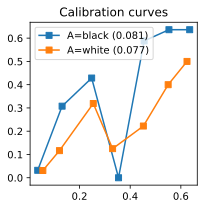

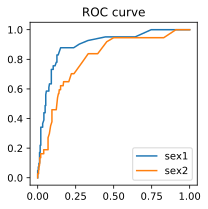

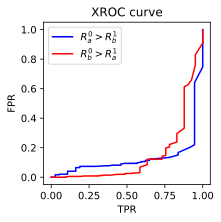

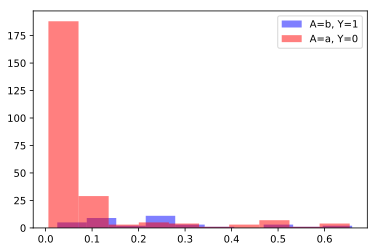

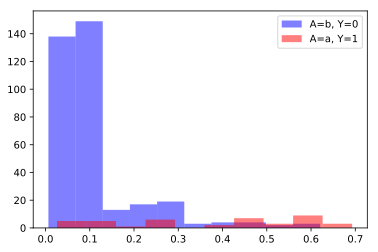

In [60]:
## Parole 
parole = pd.read_csv('fairness-datasets/parole.csv')
parole.head()
parole_labels=['black', 'white']
A_parole = (parole['race']==1).values.astype(int) 
#Originally: race: 1 if the parolee is white, 2 otherwise
Y_parole = parole['violator']
X_parole = parole.drop(['race', 'violator'], axis=1)
X_parole = pd.get_dummies(X_parole, columns=['state','crime'], drop_first=True)
X_parole_array = X_parole.values
X_cols = [c for c in X_parole.columns]
parole_processed = { 'X': X_parole_array, 'cols':X_cols, 'A': A_parole, 'Y':Y_parole,'classes':{0:'black',1:'white'}  }
pickle.dump(parole_processed, open('parole_processed.p','wb'))
[clf_parole, Rhat_parole] = get_lr(X_parole, Y_parole)

[ROCs_p, XROC_p, XROC_backwards_p, Rhata0_cross_Rhatb1_p,Rhatb0_cross_Rhata1_p] = get_diagnostics(Rhat_parole, X_parole, A_parole, Y_parole,parole_labels, n_thresh)


In [ ]:
def tied_rank(x):
    """
    Computes the tied rank of elements in x.
    This function computes the tied rank of elements in x.
    Parameters
    ----------
    x : list of numbers, numpy array
    Returns
    -------
    score : list of numbers
            The tied rank f each element in x
    """
    sorted_x = sorted(zip(x,range(len(x))))
    r = [0 for k in x]
    cur_val = sorted_x[0][0]
    last_rank = 0
    for i in range(len(sorted_x)):
        if cur_val != sorted_x[i][0]:
            cur_val = sorted_x[i][0]
            for j in range(last_rank, i): 
                r[sorted_x[j][1]] = float(last_rank+1+i)/2.0
            last_rank = i
        if i==len(sorted_x)-1:
            for j in range(last_rank, i+1): 
                r[sorted_x[j][1]] = float(last_rank+i+2)/2.0
    return r

def auc(actual, posterior):
    """
    Computes the area under the receiver-operater characteristic (AUC)
    This function computes the AUC error metric for binary classification.
    Parameters
    ----------
    actual : list of binary numbers, numpy array
             The ground truth value
    posterior : same type as actual
                Defines a ranking on the binary numbers, from most likely to
                be positive to least likely to be positive.
    Returns
    -------
    score : double
            The mean squared error between actual and posterior
    """
    r = tied_rank(posterior)
    num_positive = len([0 for x in actual if x==1])
    num_negative = len(actual)-num_positive
    sum_positive = sum([r[i] for i in range(len(r)) if actual[i]==1])
    auc = ((sum_positive - num_positive*(num_positive+1)/2.0) /
           (num_negative*num_positive))
    return auc